# Funciones Adicionales

In [2]:
library(MASS)
library(rpart)
library(class)
library(readr)
library(ggplot2)
install.packages("kernlab")
library(kernlab)
install.packages("dplyr")
library(dplyr)
install.packages("randomForest")
library(randomForest)
install.packages("xgboost")
library(xgboost)
install.packages("e1071")
library(e1071)
install.packages("future")
library(future)
install.packages("future.apply")
library(future.apply)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘xgboost’


The following objec

In [2]:
cargar_subsample <- function(file_path, n) {
  data <- read.csv(file_path, header = TRUE, stringsAsFactors = FALSE)

  mitad <- floor(nrow(data) / n)

  data_subsample <- data[sample(1:nrow(data), mitad), ]

  return(data_subsample)
}

In [3]:
getTrainTest <- function(x, y, train_ratio) {
  n <- nrow(x)

  train_indices <- sample(1:n, size = floor(train_ratio * n))

  xTrain <- x[train_indices, ]
  yTrain <- y[train_indices]

  xTest <- x[-train_indices, ]
  yTest <- y[-train_indices]

  return(list(
    xTrain = xTrain,
    yTrain = yTrain,
    xTest = xTest,
    yTest = yTest
  ))
}

In [4]:
forward.ranking <- function(x,y,method,verbosity=0,... ) {

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}

	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		    features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",list.feat,"\n")
	}

 	return(list.feat)

}

rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0) {
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

lda.est <- function(x.train,y) {
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}

error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4) {
  invisible(capture.output(model <- ksvm(as.matrix(x.train), as.factor(y), type=type,kernel=kernel,C=C,cross = cross)))
    return ( model@cross )
}

imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0) {
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}

imp.linsvm <- function(x.train,y,C=100) {
  num.feat<-dim(x.train)[2]
  tot.problems<-nlevels(y)*(nlevels(y)-1)/2

  invisible(capture.output(m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)))

  w<-rep(0.0,num.feat)
  for(i in 1:tot.problems) for(feat in 1:num.feat)
      w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
  rank.list<-sort(w,decreasing=FALSE,index=T)
  return(list(feats=rank.list$ix,imp=rank.list$x))
}

crea.ruido.unif<-function(n=100,d=2) {
  x<-runif(2*n*d,min=-1)	#genero los datos
  dim(x)<-c(2*n,d)
  return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

greedyBackward <- function(x, y, method, ...) {
	max.feat<-dim(x)[2]
	num.feat<-dim(x)[2]
	list.feat<-1:num.feat

	class.error<-double(num.feat)

	for(i in 1:max.feat){
		x.train<-x[,list.feat[-i],drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)))
	}

	list.feat[max.feat]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

  num.feat<-num.feat-1

	while(num.feat>1){
		class.error<-double(num.feat)
		for(i in 1:num.feat){
			x.train<-x[,keep.feat[-i],drop=F]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)))
		}

		best.index<-which.min(class.error)

		list.feat[num.feat]<-keep.feat[best.index]

		keep.feat<-keep.feat[-best.index]
		num.feat<-num.feat-1
	}

  list.feat[1] = keep.feat[1]

 	return(list.feat)
}

kruskalWallis <- function(x, y) {
  max.feat<-dim(x)[2]
  class.error <- double(dim(x)[2])

  for (i in 1:max.feat){
    x.train<-x[,i]
    class.error[i] <- kruskal.test(x.train,y)$p.value
  }

  return(order(class.error))
}

rfe <- function(x, y, method, ...) {
  max.feat <- dim(x)[2]
  list.feat <- 1:max.feat
  keep.feat <- 1:max.feat

  for (i in 1:max.feat){
    class.error <- do.call(method, c(list(x[, keep.feat, drop=F], y), list(...)))
    least.important <- class.error$feats[1]
    list.feat[max.feat - i + 1] <- keep.feat[least.important]
    keep.feat <- keep.feat[-least.important]
  }

  return (list.feat)
}

In [5]:
nReferences <- function(dataset, n) {
  rows <- nrow(dataset)
  cols <- ncol(dataset)

  pca <- prcomp(dataset)
  rangos <- apply(pca$x, 2, range)

  references <- list()

  for(i in 1:n){
    reference <- c()

    components <- min(ncol(pca$x), cols)

    for(j in 1:components) {
      uniformColumn = runif(rows, rangos[1, j], rangos[2, j])
      reference = cbind(reference, uniformColumn)
    }

    references[[i]] <- reference
  }

  return(references)
}

gapStatistic <- function(dataset, maxK, B) {
  wkb <- double(maxK)
  gap <- double(maxK)
  sk <- double(maxK)

  references <- nReferences(dataset, B)

  for(k in 2:maxK){
      wk <- kmeans(dataset, k)$tot.withinss

      for(b in 1:B){
          wkb[b] <- kmeans(references[[b]],k)$tot.withinss
      }

      gap[k] <- (1/B) * sum(log(wkb)) - log(wk)
      l <- (1/B) * sum(log(wkb))
      sd <- sqrt(1/B * sum((log(wkb) - l)^2))
      sk[k] <- sd * sqrt(1 + 1/B)
  }

  numClusters <- 2
  while(numClusters < maxK && gap[numClusters] < gap[numClusters + 1] - sk[numClusters + 1]) {
    numClusters = numClusters + 1
  }

  return (numClusters)
}

stabilityScore <- function(n, ind1, ind2, cc1, cc2) {
  v1 <- v2 <- rep(0, n)
  v1[ind1] <- cc1 + 5
  v2[ind2] <- cc2 + 5

  a <- sqrt(v1%*%t(v1))
  m1 <- a / -a + 2 * (a == round(a))
  m1[is.nan(m1)] <- 0

  a <- sqrt(v2%*%t(v2))
  m2 <- a / -a + 2 * (a == round(a))
  m2[is.nan(m2)] <- 0

  validos <- sum(v1 * v2 > 0)
  return (sum((m1*m2)[upper.tri(m1)] > 0) / (validos * (validos - 1) / 2))
}

stability <- function(dataset, k, n, sampling) {
  rows <- nrow(dataset)

  subsamples <- list()
  for(i in 1:n){
    subsamples[[i]] <- sample(rows, rows*sampling)
  }

  stabilityMean <- c()

  for(clusters in 2:k){
    kmeansSubsamples <- list()

    for(i in 1:n){
      kmeansSubsamples[[i]] <- kmeans(dataset[subsamples[[i]], ], clusters, nstart=20, iter.max=100)$cluster
    }

    stabilityScores <- c()

    for(ind1 in 1:(n - 1)){
      for(ind2 in (ind1 + 1):n){
        stabilityScores <- c(stabilityScores, stabilityScore(rows, subsamples[[ind1]], subsamples[[ind2]], kmeansSubsamples[[ind1]], kmeansSubsamples[[ind2]]))
      }
    }

    stabilityMean <- c(stabilityMean, mean(stabilityScores))
  }

  return (length(stabilityMean) - which.max(rev(stabilityMean)) + 2)
}

# Dataset

Para este trabajo, utilicé el dataset ["Classify gestures by reading muscle activity"](https://www.kaggle.com/datasets/kyr7plus/emg-4). Este dataset consiste en registros obtenidos al colocar 8 sensores de activación muscular en el brazo de una persona mientras realizaba diferentes gestos: "ok", "piedra", "papel" y "tijera". Cada gesto fue grabado 6 veces durante 20 segundos. Cada grabación contiene 8 mediciones generadas por cada sensor.

El objetivo del trabajo es intentar predecir qué gesto realizó la persona a partir de los datos proporcionados por los sensores.

In [ ]:
archivo1 <- cargar_subsample("0.csv", 2)
archivo2 <- cargar_subsample("1.csv", 2)
archivo3 <- cargar_subsample("2.csv", 2)
archivo4 <- cargar_subsample("3.csv", 2)

archivo1 <- setNames(archivo1, 1:65)
archivo2 <- setNames(archivo2, 1:65)
archivo3 <- setNames(archivo3, 1:65)
archivo4 <- setNames(archivo4, 1:65)

dataset_combinado <- bind_rows(archivo1, archivo2, archivo3, archivo4)

dataset_combinado <- dataset_combinado[sample(1:nrow(dataset_combinado)), ]

x <- dataset_combinado[, -65]
y <- as.factor(dataset_combinado[, 65])

resultados <- getTrainTest(x, y, 0.7)
xBigTrain <- resultados$xTrain
yBigTrain <- resultados$yTrain
xBigTest <- resultados$xTest
yBigTest <- resultados$yTest

resultados <- getTrainTest(xBigTrain, yBigTrain, 0.7)
xTrain <- resultados$xTrain
yTrain <- resultados$yTrain
xTest <- resultados$xTest
yTest <- resultados$yTest

Antes de comenzar a trabajar con el dataset, para evaluar si valía la pena estudiar este problema, probé ejecutar el dataset completo utilizando Random Forest, ajustando los valores de mtry a 64, 32, 16, 8, 4, 2 y 1. A partir de estas pruebas, obtuve un error de aproximadamente un 7% en el mejor caso. Al observar que este error no era tan alto como para que el problema pareciera imposible de resolver, pero tampoco tan bajo como para descartar la posibilidad de obtener mejores resultados con otros modelos, decidí avanzar con este dataset y explorar qué técnicas de manejo de datos podrían ayudar a reducir el error.

Antes de analizar modelos que generaran rankings de importancia de variables, decidí ejecutar Random Forest considerando únicamente 8 variables a la vez (la medición n-ésima de los sensores). Esto se debía a que me parecía curioso que cada registro incluyera 8 mediciones por sensor, en lugar de dividirlas en múltiples registros.

Al realizar estas pruebas, noté que, aunque los errores obtenidos no eran extremadamente altos, ninguno fue inferior al 25%. A partir de esto, deduje que es crucial estudiar el problema utilizando todas las mediciones de los sensores, ya que una única medición por sensor no es suficiente para obtener resultados satisfactorios.

# Visualizacion

Antes de analizar las variables, quise visualizar los datos para observar si era posible identificar visualmente si algunas variables eran más importantes que otras. Dado que se tienen 64 variables, realicé un análisis de componentes principales (PCA) y ploteé las primeras 5 componentes utilizando diagramas de pares (pairs).

Es importante aclarar que no realicé un summary de los datos, ya que todos los sensores devuelven valores en un rango fijo entre -128 y 128.

In [ ]:
pca_result <- prcomp(scale(x), center = TRUE)

pca_data <- as.data.frame(pca_result$x[, 1:5])

Clases y sus colores asociados:
'rock' (0): red
'scissors' (1): blue
'paper' (2): green
'ok' (3): black


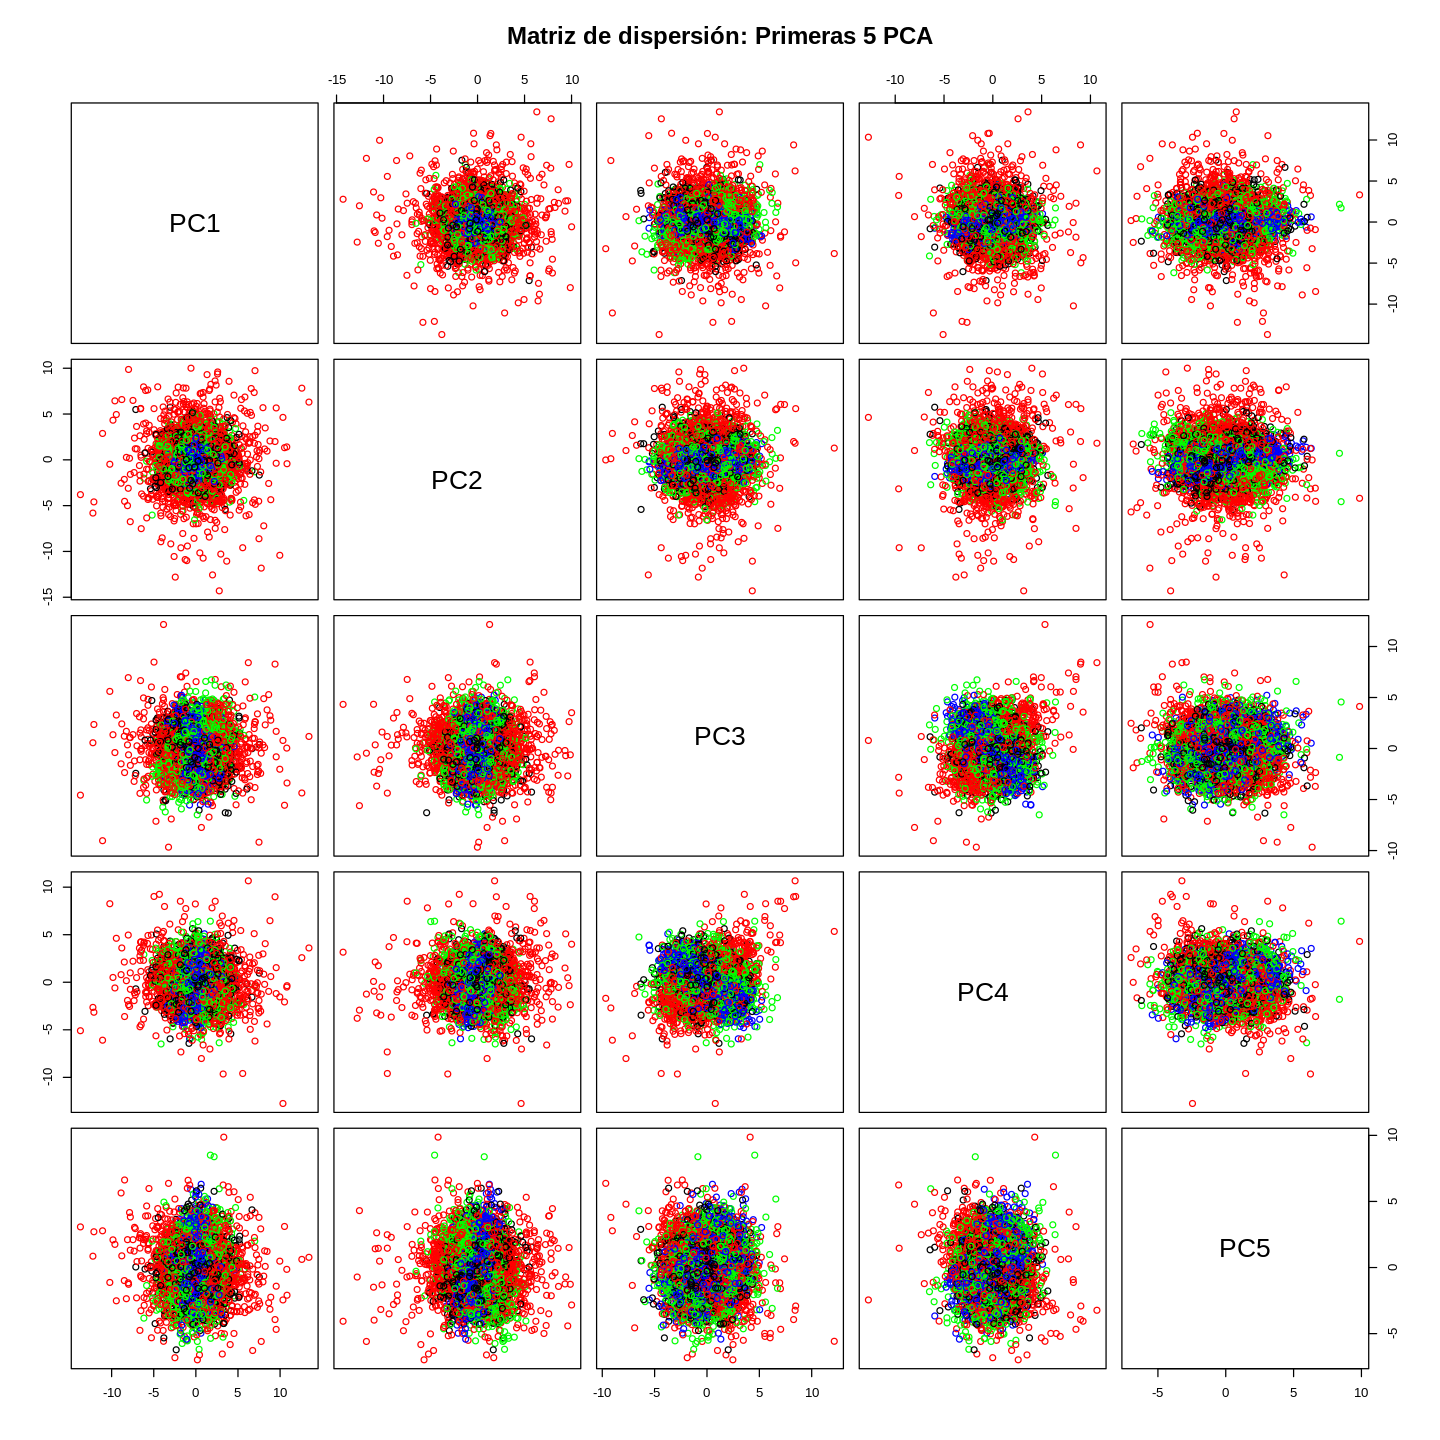

In [ ]:
class_labels <- c("rock", "scissors", "paper", "ok")
class_colors <- c("red", "blue", "green", "black")

y_numeric <- as.numeric(as.character(y))

par(mar = c(2, 2, 2, 8))

pairs(pca_data,
      col = class_colors[y_numeric + 1],
      main = "Matriz de dispersión: Primeras 5 PCA")

cat("Clases y sus colores asociados:\n")
for (i in seq_along(class_labels)) {
  cat(sprintf("'%s' (%d): %s\n", class_labels[i], i - 1, class_colors[i]))
}

Como se puede observar, las muestras están casi completamente superpuestas, lo que impide identificar clusters de manera clara. Sin embargo, en algunas combinaciones, como entre las componentes principales PC2 y PC5, es posible notar ligeras divisiones en los datos, donde se forman franjas que podrían estar asociadas a cada clase.

De todas formas, esta observación no resulta útil para determinar clusters, ya que, en última instancia, todos los valores permanecen agrupados en una misma masa indistinta.

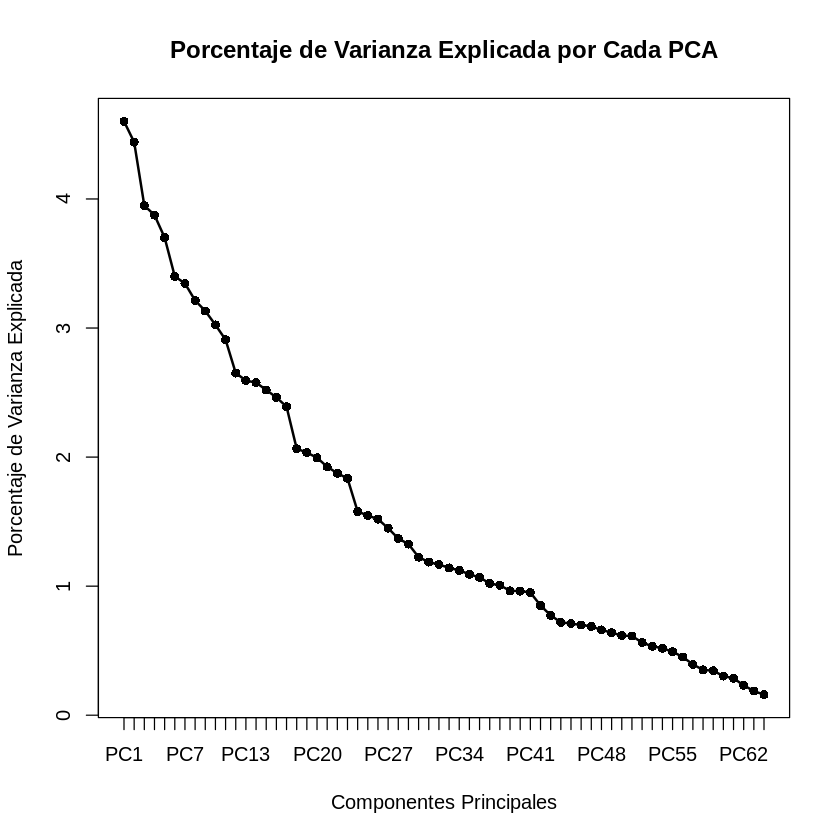

In [ ]:
percent_variance_explained <- (pca_result$sdev^2 / sum(pca_result$sdev^2)) * 100

plot(percent_variance_explained,
     type = "p",
     pch = 16,
     col = "black",
     xlab = "Componentes Principales",
     ylab = "Porcentaje de Varianza Explicada",
     main = "Porcentaje de Varianza Explicada por Cada PCA",
     xaxt = "n")

lines(1:length(percent_variance_explained), percent_variance_explained, col = "black", lwd = 2)

axis(1, at = 1:length(percent_variance_explained), labels = paste0("PC", 1:length(percent_variance_explained)))


Siguiendo con lo mencionado anteriormente, al estar todas las muestras tan agrupadas en cada PCA, no resulta sorprendente que la varianza explicada por estas sea baja y que la disminución de varianza entre una componente y otra sea mínima. Esto se debe a que, dado que los datos están tan juntos, no es posible separarlos de manera efectiva en el espacio de las componentes principales.

In [ ]:
modify_variable_names <- function(names) {
  modified_names <- sapply(names, function(x) {
    n <- as.integer(gsub("[^0-9]", "", x))  # Extraer el número de la etiqueta
    if (n %% 8 == 0) {
      return("8")  # Cambiar a "8" si n % 8 == 0
    } else {
      return(n %% 8)  # Dejar el valor original si no cumple la condición
    }
  })
  return(modified_names)
}

y <- x

# Suponiendo que 'x' es tu matriz de datos
colnames(y) <- modify_variable_names(colnames(y))

# Realizar el PCA sobre los datos modificados
pca_result <- prcomp(y, center = TRUE, scale. = TRUE)

# Extraer las primeras 5 componentes principales
pca_data <- as.data.frame(pca_result$x[, 1:5])

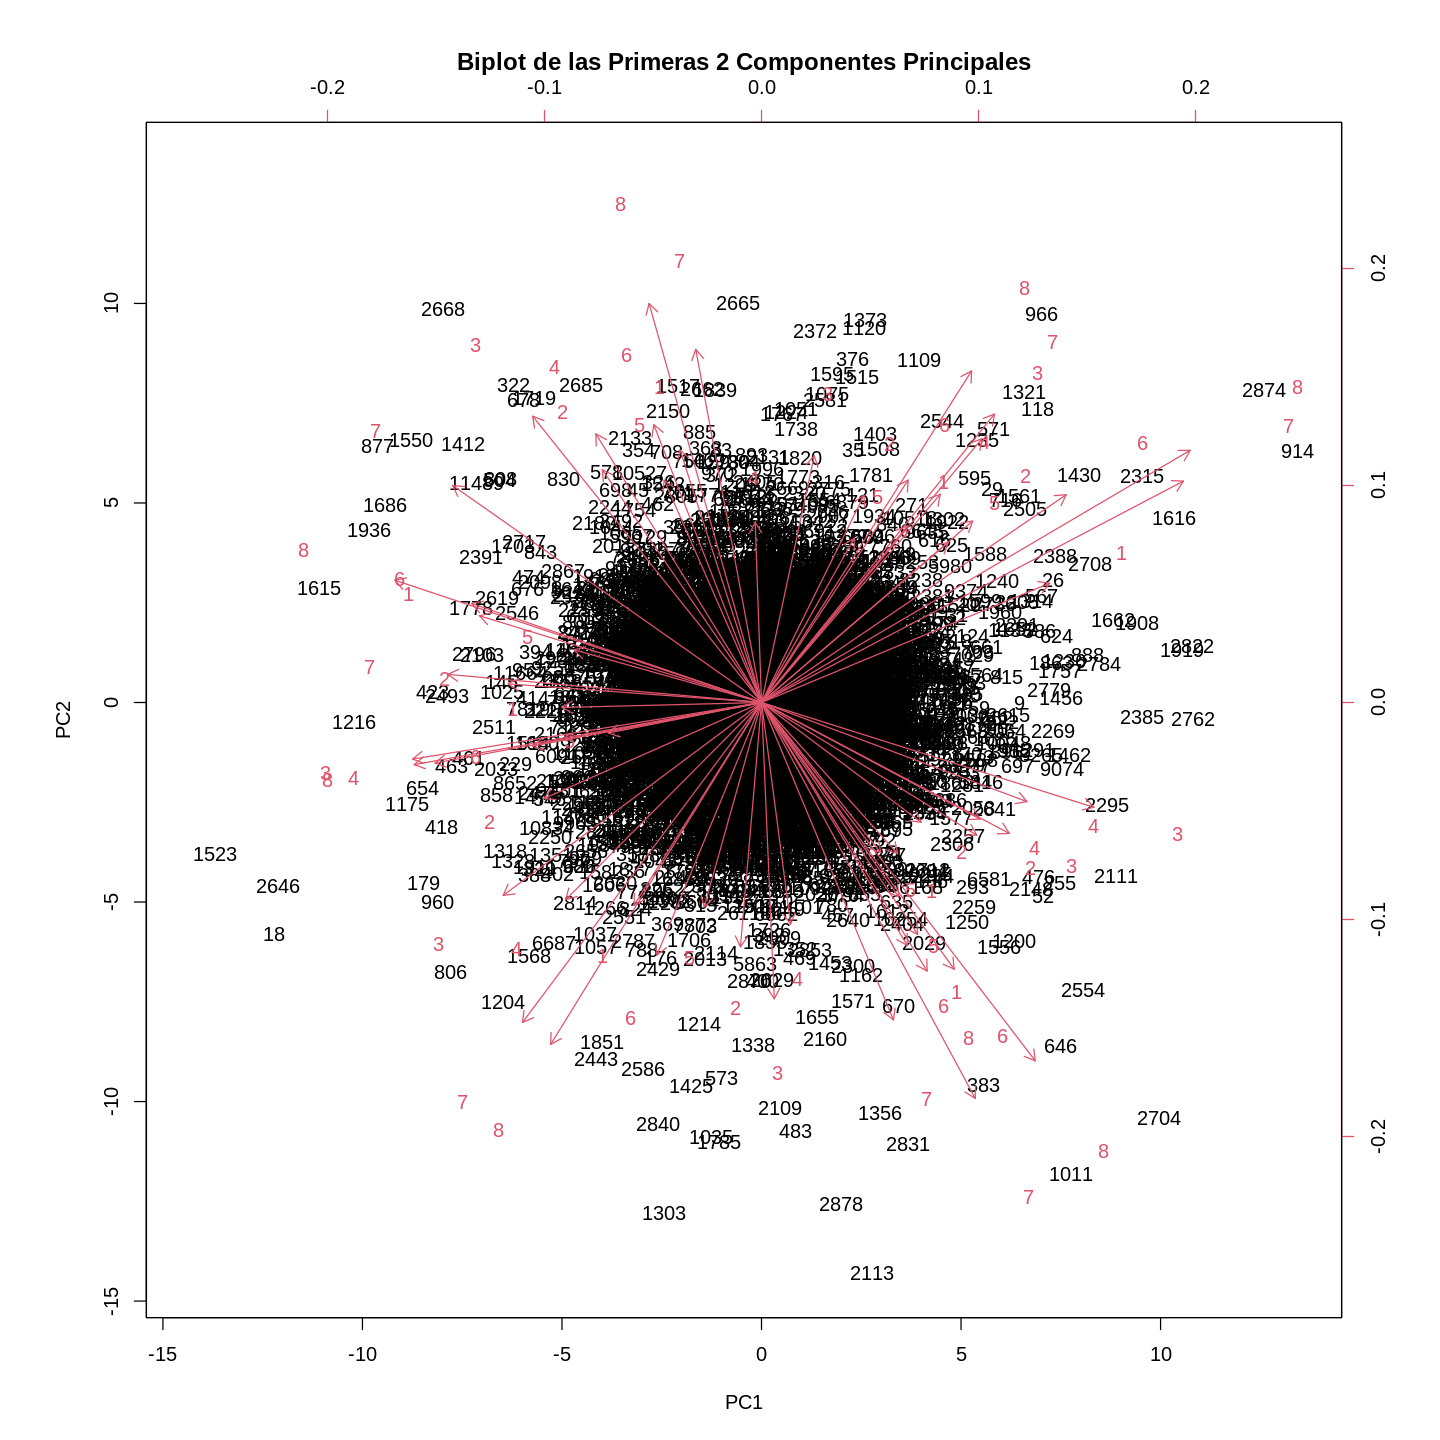

In [ ]:
biplot(pca_result, scale = 0, main = "Biplot de las Primeras 2 Componentes Principales")

Antes de realizar el biplot, y con el objetivo de facilitar la interpretación de qué variables están contribuyendo a las principales PCAs, decidí renombrar las variables para reflejar a qué sensor correspondía cada dato.

Sin embargo, como era de esperarse, no logré encontrar correlaciones relevantes entre las variables y las PCAs. Correlaciones significativas podrían haber sido, por ejemplo, que las mediciones del sensor 7 estuvieran alineadas principalmente con el eje de la PC1, pero no se observó este tipo de relación en los datos.

# Feature Selection

In [ ]:
cat("Greedy Forward rf.est: ", forward.ranking(x,y,method="rf.est"))
cat("\nGreedy Forward svm.est: ", forward.ranking(x,y,method="svm.est"))
cat("\nGreedy Forward lda.est: ", forward.ranking(x,y,method="lda.est"))
cat("\nGreedy Backward rf.est: ", greedyBackward(x,y,method="rf.est"))
cat("\nGreedy Backward svm.est: ", greedyBackward(x,y,method="svm.est"))
cat("\nGreedy Backward lda.est: ", greedyBackward(x,y,method="lda.est"))
cat("\nKruskal Wallis: ", kruskalWallis(x,y))
cat("\nRFE imp.rf: ", rfe(x,y,method="imp.rf"))
cat("\nRFE imp.linsvm: ", rfe(x,y,method="imp.linsvm"))

Greedy Forward rf.est:  15 10 63 58 39 7 47 18 34 31 42 2 62 55 14 30 50 23 38 46 21 54 13 26 36 33 19 6 41 11 61 43 35 22 56 57 28 27 9 60 52 20 17 25 29 1 59 45 24 32 12 64 8 49 48 44 51 40 5 3 53 4 37 16
Greedy Forward svm.est:  63 34 38 58 28 23 36 18 7 15 50 64 47 59 11 30 22 20 62 46 39 60 26 43 10 2 12 48 53 55 51 56 24 14 31 19 6 35 52 54 40 32 8 27 37 42 49 25 57 1 61 9 17 4 33 13 3 29 16 5 45 44 41 21
Greedy Forward lda.est:  55 33 6 41 34 39 42 12 36 45 4 31 7 9 18 35 24 26 2 50 47 63 52 32 16 20 15 23 44 58 10 49 60 56 3 59 57 19 28 43 61 25 40 30 37 53 22 17 51 38 46 48 11 14 62 27 1 54 64 21 29 13 8 5
Greedy Backward rf.est:  63 58 7 39 18 55 42 31 2 23 15 47 26 30 54 41 62 22 57 34 4 46 10 17 35 38 25 6 44 11 28 12 3 49 19 60 1 29 33 13 14 21 61 9 48 8 24 20 51 36 37 45 64 56 53 52 5 50 16 43 32 59 27 40
Greedy Backward svm.est:  55 47 34 42 27 6 14 40 60 30 45 63 28 50 48 4 37 39 31 12 56 10 51 32 15 13 5 33 25 21 59 38 7 20 53 26 46 23 2 52 41 35 64 11 61 58 16 22 29 1

In [ ]:
Las variables que devuelven los metodo de seleccion estan relacionadas a los siguientes sensores:

Greedy Forward rf.est: 7 2 7 2 7 7 7 2 2 7 2 2 6 7 6 6 2 7 6 6 5 6 5 2 4 1 3 6 1 3 5 3 3 6 8 1 4 3 1 4 4 4 1 1 5 1 3 5 8 8 4 8 8 1 8 4 3 8 5 3 5 4 5 8

Greedy Forward svm.est: 7 2 6 2 4 7 4 2 7 7 2 8 7 3 3 6 6 4 6 6 7 4 2 3 2 2 4 8 5 7 3 8 8 6 7 3 6 3 4 6 8 8 8 3 5 2 1 1 1 1 5 1 1 4 1 5 3 5 8 5 5 4 1 5

Greedy Forward lda.est: 7 1 6 1 2 7 2 4 4 5 4 7 7 1 2 3 8 2 2 2 7 7 4 8 8 4 7 7 4 2 2 1 4 8 3 3 1 3 4 3 5 1 8 6 5 5 6 1 3 6 6 8 3 6 6 3 1 6 8 5 5 5 8 5

Greegy Backward rf.est: 7 2 7 7 2 7 2 7 2 7 7 7 2 6 6 1 6 6 1 2 4 6 2 1 3 6 1 6 4 3 4 4 3 1 3 4 1 5 1 5 6 5 5 1 8 8 8 4 3 4 5 5 8 8 5 4 5 2 8 3 8 3 3 8

Greedy Backward svm.est: 7 7 2 2 3 6 6 8 4 6 5 7 4 2 8 4 5 7 7 4 8 2 3 8 7 5 5 1 1 5 3 6 7 4 5 2 6 7 2 4 1 3 8 3 5 2 8 6 5 3 4 1 3 6 6 1 1 4 8 3 2 1 8 1

Greedy Backward lda.est: 7 5 2 4 5 7 2 2 7 7 6 7 7 1 4 7 4 6 1 6 6 4 6 6 3 3 8 1 8 3 3 6 8 3 6 1 7 8 8 4 1 5 5 5 2 5 4 2 8 2 5 2 4 1 3 8 2 3 4 3 1 1 5 8

Kruskal Wallis: 1 7 7 4 4 7 7 1 1 7 4 6 7 1 4 1 6 4 2 4 7 6 4 7 6 2 1 2 8 2 5 3 4 6 1 2 5 6 6 5 3 5 3 1 8 5 6 2 3 8 3 2 3 8 8 8 5 5 5 8 2 8 3 3

RFE imp.rf: 7 7 2 2 7 7 7 7 7 2 2 7 2 2 2 2 1 1 1 6 6 1 1 6 4 6 6 3 6 6 1 4 4 3 6 4 3 4 3 4 4 3 8 3 3 3 8 8 8 1 4 8 1 8 8 5 5 8 5 5 5 5 5 5

RFE imp.linsvm: 7 7 7 7 7 7 4 3 1 1 2 3 7 5 8 5 2 1 8 1 6 1 3 6 7 6 6 6 5 5 2 3 4 6 5 2 5 3 3 2 4 4 4 8 3 5 6 2 1 4 8 3 4 1 2 1 5 6 8 8 8 8 4 2

Aunque los resultados obtenidos muestran algunas diferencias, parece que los sensores que aportan datos más relevantes suelen ser el 2 y el 7, mientras que los que menos contribuyen (si es que no introducen ruido) son el 5 y el 8. El resto de los sensores tienden a posicionarse en un nivel intermedio dentro del ranking de importancia.

Por lo tanto, probaré entrenar un modelo de Random Forest utilizando las siguientes combinaciones de sensores: únicamente el 2 y el 7; todos los sensores; y todos excepto el 5 y el 8. Compararé los errores obtenidos en cada caso para decidir si es conveniente eliminar algunas variables del dataset.

In [ ]:
getErrors <- function(mtrys, x, y) {
  plan(multisession)

  arboles <- 1000
  tries <- 5

  calcular_error_mtry <- function(mtry) {
  error <- 0
  for (j in 1:tries) {
    rf_model <- randomForest(x = x, y = y,
                            ntree = arboles,
                            mtry = mtry,
                            importance = FALSE)
    error <- error + tail(rf_model$err.rate[, "OOB"], 1)
  }
  error / tries
  }

  errores <- future_sapply(mtrys, calcular_error_mtry, future.seed = TRUE)

  print(setNames(errores, mtrys))

  plan(sequential)
}

In [ ]:
k <- 0:7

print("2")
getErrors(c(8, 4, 2, 1), x[, c(k * 8 + 2)], y)
print("7")
getErrors(c(8, 4, 2, 1), x[, c(k * 8 + 7)], y)
print("2 y 7")
getErrors(c(16, 8, 4, 2, 1), x[, c(k * 8 + 2, k * 8 + 7)], y)
print("Todos")
getErrors(c(64, 32, 16, 8, 4, 2, 1), x, y)
print("Todos menos 5")
getErrors(c(56, 32, 16, 8, 4, 2, 1), x[, -(c(k * 8 + 5))], y)
print("Todos menos 8")
getErrors(c(56, 32, 16, 8, 4, 2, 1), x[, -(c(k * 8 + 8))], y)
print("Todos menos 5 y 8")
getErrors(c(48, 32, 16, 8, 4, 2, 1), x[, -(c(k * 8 + 5, k * 8 + 8))], y)

[1] "2"
        8         4         2         1 
0.5000367 0.4987884 0.4972953 0.4909069 
[1] "7"
        8         4         2         1 
0.3184433 0.3158977 0.3143312 0.3119080 
[1] "2 y 7"
       16         8         4         2         1 
0.1102191 0.1089218 0.1069147 0.1037572 0.1007710 
[1] "Todos"
        64         32         16          8          4          2          1 
0.08963407 0.09115163 0.08982989 0.08236446 0.07416473 0.06821686 0.06804553 
[1] "Todos menos 5"
        56         32         16          8          4          2          1 
0.08941378 0.09134745 0.09161669 0.08630523 0.07773834 0.07223106 0.07328356 
[1] "Todos menos 8"
        56         32         16          8          4          2          1 
0.08811651 0.08912006 0.08926692 0.08324562 0.07201077 0.06449639 0.06420267 
[1] "Todos menos 5 y 8"
        48         32         16          8          4          2          1 
0.08838575 0.08946273 0.09073553 0.08672133 0.07715090 0.06875535 0.06755599 


Al observar que los errores más bajos se obtienen al eliminar las variables relacionadas con el sensor 8, continuaré evaluando los datasets sin incluir dichas variables.

Mientras evaluaba estos sub-datasets, algo interesante que noté es que casi todos los mejores errores se lograron al tomar una sola variable a la vez para dividir los nodos del árbol. Honestamente, no estoy seguro de a qué se debe esto. Entiendo que, en última instancia, todas las variables se consideran para hacer los cortes en los nodos, pero supuse que habría sido más efectivo elegir la variable más adecuada entre las posibles, en lugar de dividir siempre utilizando una variable seleccionada aleatoriamente.

Parece que, en este dataset, el aumento de varianza entre los árboles (al seleccionar el mtry más pequeño) tuvo un impacto positivo en los resultados.

In [ ]:
k <- 0:7
indices <- c(k * 8 + 8)

x <- x[, -indices]
xBigTrain <- xBigTrain[, -indices]
xBigTest <- xBigTest[, -indices]
xTrain <- xTrain[, -indices]
xTest <- xTest[, -indices]

# Clusters

In [ ]:
kmeansFunc <- function(x, y, clusters = 4, iter.max = 30, nstart = 20) {
  clust <- kmeans(x, clusters, iter.max, nstart)

  cont.table <- table(y, clust$cluster)
  class.match <- matchClasses(as.matrix(cont.table), method="exact")

  print(cont.table[, class.match])
}

In [3]:
transformaciones <- list(
  "Base" = function(x) x,
  "Log" = function(x) log(x),
  "Log + Scale" = function(x) as.data.frame(scale(log(x))),
  "Log + Scale + PCA" = function(x) as.data.frame(prcomp(scale(log(x)))$x),
  "Log + PCA + Scale" = function(x) as.data.frame(scale(prcomp(log(x))$x)),
  "Scale" = function(x) as.data.frame(scale(x)),
  "Scale + PCA" = function(x) as.data.frame(prcomp(scale(x))$x),
  "PCA + Scale" = function(x) as.data.frame(scale(prcomp(x)$x))
)

## Sin sensor 8

In [ ]:
plan(multisession)

future_lapply(names(transformaciones), function(nombre) {
  print(nombre)
  x_transformado <- transformaciones[[nombre]](x)
  kmeansFunc(x_transformado, y)
})

plan(sequential)

for (nombre in names(clusters)) {
  print(nombre)
  cont.table <- clusters[[nombre]]

  class.match <- matchClasses(as.matrix(cont.table), method = "exact")

  print(cont.table[, class.match])
}

[1] "Base"
Direct agreement: 0 of 4 pairs
Iterations for permutation matching: 24 
Cases in matched pairs: 26.19 %
   
y     4   1   2   3
  0 779 699 765 666
  1 657 739 680 826
  2 748 681 750 763
  3 722 695 715 789
[1] "Log"
Direct agreement: 0 of 4 pairs
Iterations for permutation matching: 24 
Cases in matched pairs: 27.7 %
   
y      4    3    2    1
  0  229  106 1383 1191
  1    0    0 1624 1278
  2    0    0 1655 1287
  3    0    0 1571 1350
[1] "Log + Scale"
Direct agreement: 0 of 4 pairs
Iterations for permutation matching: 24 
Cases in matched pairs: 28.51 %
   
y      3    1    2    4
  0  248  901  965  795
  1    0 1053  861  988
  2    0  967 1002  973
  3    0 1042  854 1025
[1] "Log + Scale + PCA"
Direct agreement: 0 of 4 pairs
Iterations for permutation matching: 24 
Cases in matched pairs: 27.93 %
   
y      1    2    4    3
  0  249  846  855  959
  1    0 1073  929  900
  2    0  987  944 1011
  3    0 1016  911  994
[1] "Log + PCA + Scale"
Direct agreement: 0 of

Como era de esperarse, a partir de los resultados de la visualización, donde se observó que las variables de todas las clases estaban solapadas, no se logró encontrar los 4 clusters esperados. Lo máximo que se alcanzó fue un porcentaje de coincidencia del 29.41%, debido a que casi todas las muestras fueron agrupadas en 3 de los 4 clusters. Esto permitió mejorar el resultado, aunque uno de los clusters terminó teniendo 400 puntos, cuando debería haber tenido cerca de 3000.

In [ ]:
resultados <- lapply(names(transformaciones), function(nombre) {
  x_transformado <- transformaciones[[nombre]](x)

  gap <- gapStatistic(x_transformado, 8, 100)
  stab <- stability(x_transformado, 8, 10, 0.7)

  list(Transformacion = nombre, GAP = gap, Stability = stab)
})

resultados_por_modelo <- list(
  GAP = sapply(resultados, function(res) res$GAP, simplify = TRUE),
  Stability = sapply(resultados, function(res) res$Stability, simplify = TRUE)
)

cat("Resultados por Modelo\n")
cat("Modelo: GAP\n")
for (i in seq_along(resultados_por_modelo$GAP)) {
  cat(names(transformaciones)[i], ":", resultados_por_modelo$GAP[i], "\n")
}

cat("\nModelo: Stability\n")
for (i in seq_along(resultados_por_modelo$Stability)) {
  cat(names(transformaciones)[i], ":", resultados_por_modelo$Stability[i], "\n")
}

Resultados por Modelo
Modelo: GAP
Base : 3 
Log : 2 
Log + Scale : 2 
Log + Scale + PCA : 2 
Log + PCA + Scale : 2 
Scale : 2 
Scale + PCA : 2 
PCA + Scale : 2 

Modelo: Stability
Base : 3 
Log : 8 
Log + Scale : 8 
Log + Scale + PCA : 8 
Log + PCA + Scale : 2 
Scale : 8 
Scale + PCA : 8 
PCA + Scale : 2 


Nuevamente, como era de esperarse a partir de los resultados anteriores y de la visualización, no se logró encontrar el número de clusters adecuado con ninguna combinación de modelo y transformación de datos.

## Sensores 2 y 7

Dado que no encontré los clusters para ninguna transformación de datos, y considerando que al utilizar únicamente los sensores 2 y 7 obtuve un error del 10% con Random Forest, intentaré buscar los clusters utilizando únicamente las variables relacionadas con estos sensores. De esta manera, evaluaré si con menos variables se pueden lograr mejores aproximaciones.

In [ ]:
k <- 0:7
indices <- c(k * 8 + 2, k * 8 + 7)

xAux <- x[, indices]

In [4]:
plan(multisession)

future_lapply(names(transformaciones), function(nombre) {
  print(nombre)
  x_transformado <- transformaciones[[nombre]](xAux)
  kmeansFunc(x_transformado, y)
})

plan(sequential)

for (nombre in names(clusters)) {
  print(nombre)
  cont.table <- clusters[[nombre]]

  class.match <- matchClasses(as.matrix(cont.table), method = "exact")

  print(cont.table[, class.match])
}

[1] "Base"
Direct agreement: 1 of 4 pairs
Iterations for permutation matching: 6 
Cases in matched pairs: 29.64 %
   
y      2    4    3    1
  0  513  470 1458  468
  1    0    0 2902    0
  2    1    1 2938    2
  3    8    5 2899    9
[1] "Log"
Direct agreement: 1 of 4 pairs
Iterations for permutation matching: 6 
Cases in matched pairs: 26.77 %
   
y      4    1    2    3
  0  183   80 2537  109
  1    0    0 2902    0
  2    0    0 2942    0
  3    0    0 2921    0
[1] "Log + Scale"
Direct agreement: 0 of 4 pairs
Iterations for permutation matching: 24 
Cases in matched pairs: 32.09 %
   
y      1    2    4    3
  0  151 2117  493  148
  1    0 2891   11    0
  2    0 2238  704    0
  3    0 2887   34    0
[1] "Log + Scale + PCA"
Direct agreement: 0 of 4 pairs
Iterations for permutation matching: 24 
Cases in matched pairs: 32.76 %
   
y      1    4    3    2
  0  221 2167  414  107
  1    0 2891   11    0
  2    0 2230  712    0
  3    0 2886   35    0
[1] "Log + PCA + Scale"
Dir

Como se puede ver, se consiguieron "mejores resultados". Al evaluar el caso que mejor porcentaje de aciertos consiguio, se asigno una gran mayoria de los puntos a un unico cluster y una pequeña parte al resto. Aunque una de las clases pueda ser casi perfectamente precedible a partir de una muestra (la clase 1, piedra), en el resto de los casos casi nunca se podra predecir correctamente la clase a partir de los datos (variables de sensores 2 y 7).

In [5]:
resultados <- lapply(names(transformaciones), function(nombre) {
  x_transformado <- transformaciones[[nombre]](xAux)

  gap <- gapStatistic(x_transformado, 8, 100)
  stab <- stability(x_transformado, 8, 10, 0.7)

  list(Transformacion = nombre, GAP = gap, Stability = stab)
})

resultados_por_modelo <- list(
  GAP = sapply(resultados, function(res) res$GAP, simplify = TRUE),
  Stability = sapply(resultados, function(res) res$Stability, simplify = TRUE)
)

cat("Resultados por Modelo\n")
cat("Modelo: GAP\n")
for (i in seq_along(resultados_por_modelo$GAP)) {
  cat(names(transformaciones)[i], ":", resultados_por_modelo$GAP[i], "\n")
}

cat("\nModelo: Stability\n")
for (i in seq_along(resultados_por_modelo$Stability)) {
  cat(names(transformaciones)[i], ":", resultados_por_modelo$Stability[i], "\n")
}

Resultados por Modelo
Modelo: GAP
Base : 2 
Log : 2 
Log + Scale : 2 
Log + Scale + PCA : 2 
Log + PCA + Scale : 2 
Scale : 2 
Scale + PCA : 2 
PCA + Scale : 2 

Modelo: Stability
Base : 2 
Log : 8 
Log + Scale : 8 
Log + Scale + PCA : 8 
Log + PCA + Scale : 8 
Scale : 8 
Scale + PCA : 8 
PCA + Scale : 8 


Nuevamente, como se observó en los resultados anteriores, no sorprende que tampoco se haya podido predecir aquí el número correcto de clusters.

Algo a destacar, tanto en este caso como en el punto anterior en el que se intentó predecir la cantidad correcta de clusters, es que GAP tiende a devolver el valor 2 y Stability el valor 8. Esto ocurre por como se diseñaron dichas funciones: cuando no se encuentran resultados "satisfactorios", se retornan respectivamente el menor y el mayor número de clusters dentro del rango de búsqueda establecido.

# Ensembles

## Seleccion parametros

### Random Forest

In [ ]:
mtrys <- c(56, 32, 16, 8, 4, 2, 1)
arboles <- 1000
tries <- 5

calcular_error_mtry <- function(mtry) {
  error <- 0
  for (j in 1:tries) {
    rf_model <- randomForest(x = xBigTrain, y = yBigTrain,
                             ntree = arboles,
                             mtry = mtry,
                             importance = FALSE)
    error <- error + tail(rf_model$err.rate[, "OOB"], 1)
  }
  error / tries
}

plan(multisession)

rfParametros <- future_sapply(mtrys, calcular_error_mtry, future.seed = TRUE)

plan(sequential)

rfParametros <- setNames(rfParametros, mtrys)

print(rfParametros)

        56         32         16          8          4          2          1 
0.08767593 0.08845918 0.08912006 0.08248684 0.07237792 0.06481459 0.06449639 


Como se observó al eliminar las variables del sensor 8, el mtry 1 fue el que dio los mejores resultados (ya se comento sobre esto previamente).

### XGB

In [ ]:
XGB.nrounds <- 200
etas <- c(0.3, 0.1, 0.05, 0.01)
XGB.max.depth <- 20

xgbParametros <- matrix(NA, nrow = XGB.max.depth, ncol = length(etas),
                        dimnames = list(1:XGB.max.depth, etas))

plan(multisession)

for (depth in 1:XGB.max.depth) {
  errores <- future_sapply(etas, function(eta) {
    xgb <- xgboost(data = as.matrix(xTrain), label = as.integer(yTrain) - 1,
                   objective = "multi:softmax", num_class = 4, nrounds = XGB.nrounds,
                   early_stopping_rounds = 1000, eta = eta, max.depth = depth,
                   colsample_bytree = 1, verbose = 0, subsample = 1)

    predicciones <- predict(xgb, as.matrix(xTest))
    mean(predicciones != as.integer(yTest) - 1)
  }, future.seed = TRUE)

  xgbParametros[depth, ] <- errores
}

plan(sequential)

print(xgbParametros)

          0.3        0.1       0.05       0.01
1  0.07830343 0.12438825 0.15212072 0.20391517
2  0.06035889 0.07585644 0.10603589 0.14641109
3  0.05791191 0.06239804 0.08278956 0.11908646
4  0.05668842 0.05872757 0.07096248 0.10195759
5  0.05016313 0.05709625 0.06199021 0.09339315
6  0.05097879 0.05668842 0.05791191 0.08523654
7  0.04934747 0.05546493 0.05831974 0.08686786
8  0.05220228 0.05301794 0.05791191 0.08564437
9  0.05424144 0.05872757 0.05995106 0.08768352
10 0.05261011 0.05750408 0.06035889 0.08523654
11 0.05505710 0.05872757 0.06035889 0.08482871
12 0.05342577 0.05791191 0.06117455 0.08564437
13 0.05464927 0.05791191 0.06076672 0.08401305
14 0.05668842 0.05791191 0.06158238 0.08646003
15 0.05301794 0.06158238 0.06076672 0.08564437
16 0.05791191 0.06158238 0.06280587 0.08238173
17 0.05668842 0.05995106 0.06647635 0.08523654
18 0.05546493 0.06035889 0.06647635 0.08605220
19 0.05424144 0.05750408 0.06688418 0.08809135
20 0.05995106 0.06199021 0.06688418 0.08727569


Dado que las variables de las muestras están tan solapadas, parece tener sentido que la altura máxima del árbol sea 7, permitiendo soluciones un poco más complejas.

Lo que sí me sorprendió es que el valor de eta que dio mejores resultados fue 0.3. Honestamente, lo incluí entre los valores posibles de eta para tener más opciones, pero me sorprendió, ya que es un valor bastante alto. Esto podría hacer que las muestras tomadas en una iteración dada tengan una mayor influencia, lo que a su vez podría provocar cambios significativos en los alphas de cada árbol (ya que estos sufrirían grandes ajustes en cada iteración).

### SVM RBF

In [ ]:
rangeCost <- 0:10
costs <- 10^rangeCost
rangeGamma <- -10:0
gammas <- 10^rangeGamma

rbfParametros <- matrix(NA, nrow = length(costs), ncol = length(gammas),
                        dimnames = list(costs, gammas))

plan(multisession)

for (i in seq_along(costs)) {
  cost <- costs[i]

  # Paralelizar el cálculo sobre gammas
  errorGamma <- future_sapply(gammas, function(gamma) {
    # Entrenar el modelo SVM
    svm_rbf <- suppressWarnings(
      svm(x = xTrain, y = as.factor(yTrain), kernel = "radial", cost = cost, gamma = gamma)
    )

    # Predecir y calcular el error
    pred <- predict(svm_rbf, xTest)
    mean(pred != yTest)
  }, future.seed = TRUE)

  rbfParametros[i, ] <- errorGamma
}

plan(sequential)

print(rbfParametros)

          1e-10     1e-09     1e-08     1e-07     1e-06     1e-05     1e-04
1     0.7634584 0.7634584 0.7634584 0.7634584 0.7634584 0.7634584 0.7634584
10    0.7634584 0.7634584 0.7634584 0.7634584 0.7634584 0.7634584 0.7030995
100   0.7634584 0.7634584 0.7634584 0.7634584 0.7634584 0.7259380 0.5558728
1000  0.7634584 0.7634584 0.7634584 0.7634584 0.7255302 0.6431485 0.3058728
10000 0.7634584 0.7634584 0.7634584 0.7271615 0.6684339 0.5440457 0.1415171
1e+05 0.7634584 0.7634584 0.7222675 0.6782219 0.6362153 0.3022023 0.0954323
1e+06 0.7597879 0.7483687 0.6798532 0.6733279 0.5513866 0.1476346 0.1158238
1e+07 0.7491843 0.7479608 0.6884176 0.6647635 0.5285481 0.1476346 0.1186786
1e+08 0.7491843 0.7479608 0.6876020 0.6892333 0.5240620 0.1508972 0.1186786
1e+09 0.7491843 0.7479608 0.7010604 0.6863785 0.5216150 0.1688418 0.1186786
1e+10 0.7491843 0.7479608 0.6986134 0.7030995 0.5358891 0.1659869 0.1186786
          0.001       0.01       0.1         1
1     0.5929853 0.15334421 0.2557096 0.76

### SVM Polinomial

In [ ]:
rangeCost <- -5:5
costs <- 10^rangeCost
rangeGamma <- -5:5
gammas <- 10^rangeGamma
degrees <- 1:5

polParametros <- array(0, dim = c(length(costs), length(gammas), length(degrees)),
                           dimnames = list(costs, gammas, degrees))

plan(multisession)

for (i in 1:length(costs)) {
  cost <- costs[i]

  for (j in 1:length(gammas)) {
    gamma <- gammas[j]

    errorDegree <- future_sapply(degrees, function(degree) {
      svm_pol <- suppressWarnings(
        svm(x = xTrain, y = as.factor(yTrain), kernel = "polynomial",
            cost = cost, degree = degree, gamma = gamma)
      )
      pred <- predict(svm_pol, xTest)
      mean(pred != yTest)
    }, future.seed = TRUE)

    polParametros[i, j, ] <- errorDegree
  }
}

plan(sequential)

print(polParametros)


, , 1

          1e-05     1e-04     0.001      0.01       0.1         1        10
1e-05 0.7634584 0.7634584 0.7634584 0.7634584 0.7634584 0.7634584 0.7634584
1e-04 0.7634584 0.7634584 0.7634584 0.7634584 0.7634584 0.7634584 0.7479608
0.001 0.7634584 0.7634584 0.7634584 0.7634584 0.7634584 0.7479608 0.6823002
0.01  0.7634584 0.7634584 0.7634584 0.7634584 0.7479608 0.6823002 0.6606852
0.1   0.7634584 0.7634584 0.7634584 0.7479608 0.6823002 0.6598695 0.6606852
1     0.7634584 0.7634584 0.7479608 0.6823002 0.6606852 0.6598695 0.6586460
10    0.7634584 0.7479608 0.6823002 0.6598695 0.6610930 0.6606852 0.6818923
100   0.7479608 0.6823002 0.6606852 0.6610930 0.6598695 0.6627243 0.7349103
1000  0.6823002 0.6610930 0.6602773 0.6598695 0.6835237 0.7271615 0.7026917
10000 0.6606852 0.6610930 0.6602773 0.6810767 0.7230832 0.6990212 0.6900489
1e+05 0.6610930 0.6598695 0.6692496 0.7137031 0.7181892 0.6990212 0.6900489
            100      1000     10000     1e+05
1e-05 0.7479608 0.6823002 0.6606852

## Comparacion final

In [ ]:
errorRF <- 0
tries <- 5
rf_model <- randomForest(x = xBigTrain, y = yBigTrain,
                         ntree = 1000,
                         mtry = 1,
                         importance = FALSE)
pred <- predict(rf_model, xBigTest)
errorRF <- mean(pred != yBigTest)

cat("Error RF: ", errorRF, "\n")

xgb <- xgboost(data = as.matrix(xBigTrain), label = as.integer(yBigTrain) - 1,
               objective = "multi:softmax", num_class = 4, nrounds = 200,
               early_stopping_rounds = 1000, eta = 0.3, max.depth = 7,
               colsample_bytree = 1, verbose = 0, subsample = 1)
predicciones <- predict(xgb, as.matrix(xBigTest))
errorXGB <- mean(predicciones != as.integer(yBigTest) - 1)

cat("Error XGB: ", errorXGB, "\n")

svm_rbf <- suppressWarnings(
  svm(x = xBigTrain, y = as.factor(yBigTrain), kernel = "radial", cost = 10, gamma = 0.01)
)
pred <- predict(svm_rbf, xBigTest)
errorRBF <- mean(pred != yBigTest)

cat("Error RBF: ", errorRBF, "\n")

svm_pol <- suppressWarnings(
  svm(x = xBigTrain, y = as.factor(yBigTrain), kernel = "polynomial",
      cost = 1, degree = 2, gamma = 0.1)
)
pred <- predict(svm_pol, xBigTest)
errorPol <- mean(pred != yBigTest)

cat("Error Pol: ", errorPol, "\n")

Error RF:  0.06337425 
Error XGB:  0.04567514 
Error RBF:  0.0807879 
Error Pol:  0.09506138 


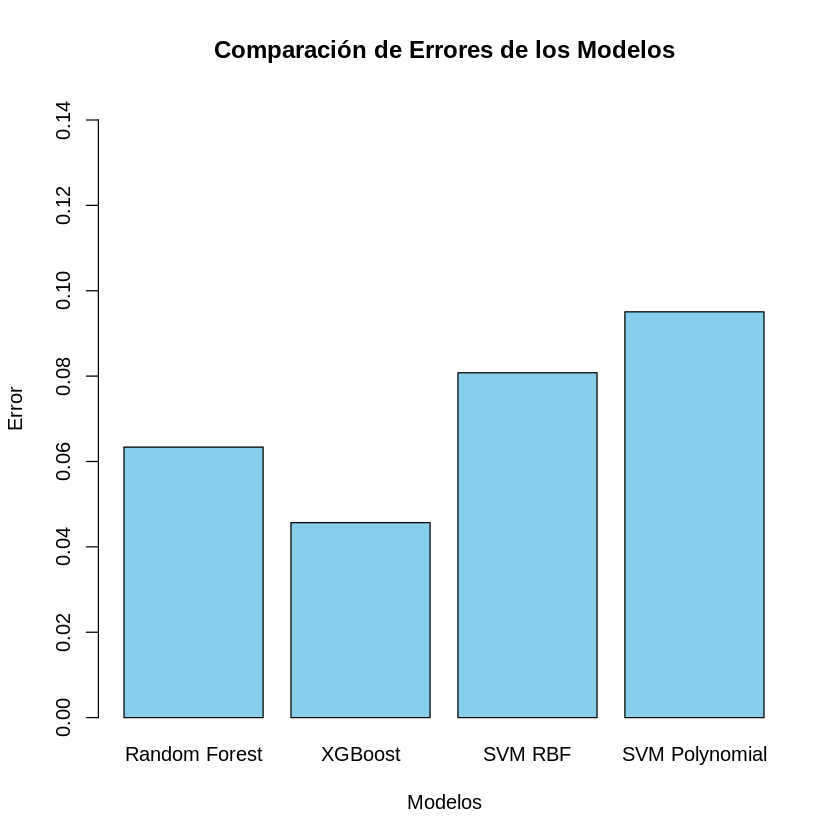

In [9]:
load("erroresFinales.RData")

errores <- c(errorRF, errorXGB, errorRBF, errorPol)
nombres_modelos <- c("Random Forest", "XGBoost", "SVM RBF", "SVM Polynomial")

barplot(
  errores,
  names.arg = nombres_modelos,
  col = "skyblue",
  main = "Comparación de Errores de los Modelos",
  ylab = "Error",
  xlab = "Modelos",
  ylim = c(0, max(errores) + 0.05)
)

Como se podía esperar, o al menos esperaba, XGBoost logró obtener mejores resultados que Random Forest. Lo sorprendente es que la mejora es casi de un 30%, pasando de un 6.3% de error a un 4.5%. Dado lo bajo del error en Random Forest (donde un modelo aleatorio tendría un 75% de error), uno esperaría que, aunque el error se reduzca con XGBoost, la mejora no fuera tan drástica.

En cuanto a los modelos de SVM, aunque los errores de 8% y 9.5% son relativamente bajos para este dataset, considerando que son un poco más altos que el de Random Forest, se observa que les afectó negativamente el hecho de que las muestras estuvieran tan solapadas. Esto se debe probablemente a que no se pudo encontrar una división adecuada para los kernels utilizados.